<a href="https://colab.research.google.com/github/armando-larocca/Project-IL-/blob/master/ICARL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import utilities**

In [1]:
import torch
import random
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torch.optim as optim 
import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.backends import * 

DEVICE = torch.device('cuda:0')

# if not os.path.isdir('./Project-dir'):
#   !git clone https://github.com/armando-larocca/Project-IL-

# if not os.path.isdir('content/cifar100.py'):
#   !mv '/content/Project-IL-/cifar100.py' '/content'  
#   !mv '/content/Project-IL-/utils.py' '/content'  

# if not os.path.isdir('content/cifarResnet.py'):
#   !mv '/content/Project-IL-/cifarResnet.py' '/content'

# if not os.path.isdir('content/icarl_utils.py'):
#   !mv '/content/Project-IL-/icarl_utils.py' '/content'  

from cifarResnet import resnet32
from cifar100 import *
from icarl_utils import * 

# Hyper Parameters
random.seed(653)
num_epochs = 70
batch_size = 128
total_classes = 100
num_classes = 10
indici_classi = list(range(0,100))
random.shuffle(indici_classi)

**Weights initialization**

In [2]:
def init_weights(m):
  if type(m) == nn.Conv2d:
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

  if type(m) == nn.Linear:
    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  

**ICARL**

In [3]:

class iCaRLNet(nn.Module):
    def __init__(self, feature_size, n_classes):
        
        #### Network architecture #### 
        super(iCaRLNet, self).__init__()
        self.feature_extractor = resnet32()
        self.fc = nn.Linear(feature_size, n_classes, bias=True)

        self.n_classes = n_classes
        self.n_known = 0

        self.cls_loss = nn.BCEWithLogitsLoss()

        self.exemplar_sets = []
        self.indexes = []

        # Means of exemplars
        self.compute_means = True
        self.exemplar_means = []

        self.apply(init_weights)



    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x



    def increment_classes(self, n):
        ### INCREMENT THE NUMBER OF OUTPUTS  ###
        ### AND COPY THE WEIGHTS            ####
        torch.no_grad()
        self.train(False)
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data
        bias = self.fc.bias.data

        self.fc = nn.Linear(in_features, out_features+n, bias=True)
        self.fc.weight.data[:out_features] = weight
        self.fc.bias.data[:out_features] = bias
        self.n_classes += n




    def classify(self, x):
        """Classify images by neares-means-of-exemplars
        Args:
            x: input image batch
        Returns:
            preds: Tensor of size (batch_size,)
        """
        torch.no_grad()
        self.train(False)
        batch_size = x.size(0)

        if self.compute_means:
            print ("Computing mean of exemplars...")
            exemplar_means = []
            for P_y in self.exemplar_sets:
                features = []
                # Extract feature for each exemplar in P_y
                for ex in P_y:
                    ex = Variable(ex, volatile=True)
                    feature = self.feature_extractor(ex.unsqueeze(0))
                    feature = feature.squeeze()
                    feature.data = feature.data / feature.data.norm() # Normalize
                    features.append(feature)
                features = torch.stack(features)
                mu_y = features.mean(0).squeeze()
                mu_y.data = mu_y.data / mu_y.data.norm() # Normalize
                exemplar_means.append(mu_y)
            self.exemplar_means = exemplar_means
            self.compute_means = False
            print ("Done")

        exemplar_means = self.exemplar_means
        means = torch.stack(exemplar_means) # (n_classes, feature_size)
        means = torch.stack([means] * batch_size) # (batch_size, n_classes, feature_size)
        means = means.transpose(1, 2) # (batch_size, feature_size, n_classes)

        feature = self.feature_extractor(x) # (batch_size, feature_size)
        for i in range(0,feature.size(0)): # Normalize
            feature.data[i] = feature.data[i] / feature.data[i].norm()
        feature = feature.unsqueeze(2) # (batch_size, feature_size, 1)
        feature = feature.expand_as(means) # (batch_size, feature_size, n_classes)

        dists = (feature - means).pow(2).sum(1).squeeze() #(batch_size, n_classes)
        _, preds = dists.min(1)

        return preds
        


    def construct_exemplar_set(self, images, indicis):
  
        """Construct an exemplar set for image set
        Args:
            images: np.array containing images of a class
        """
        torch.no_grad()
        self.train(False)
        # Compute and cache features for each example
        features = []
        for img in images:
            x = Variable(img, volatile=True)
            feature = self.feature_extractor(x.unsqueeze(0)).data.cpu().numpy()
            feature = feature / np.linalg.norm(feature) # Normalize
            features.append(feature[0])

        features = np.array(features)
        class_mean = np.mean(features, axis=0)
        class_mean = class_mean / np.linalg.norm(class_mean) # Normalize

        exemplar_set = []
        exemplar_features = [] # list of Variables of shape (feature_size,)
        indici = []
        for k in range(0, len(images)):
            S = np.sum(exemplar_features, axis=0)
            phi = features
            mu = class_mean
            mu_p = 1.0/(k+1) * (phi + S)
            mu_p = mu_p / np.linalg.norm(mu_p)
            i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
            exemplar_set.append(images[i])
            indici.append(indicis[i])
            exemplar_features.append(features[i])
          
            #print ("Selected example", i)
            #print ("|exemplar_mean - class_mean|:")
            #print (np.linalg.norm((np.mean(exemplar_features, axis=0) - class_mean)))
            features = np.delete(features, i, axis=0)
            
        #exemplar_set = torch.stack(exemplar_set)
        self.exemplar_sets.append(exemplar_set)
        #random.shuffle(indici)
        self.indexes.append(indici)        


    def reduce_exemplar_sets(self, m):
        self.train(False)
        for y, P_y in enumerate(self.exemplar_sets):
            self.exemplar_sets[y] = P_y[:int(m)]
            uff = self.indexes[y] 
            uff = uff[:int(m)]
            self.indexes[y] = uff



    def combine_dataset_with_exemplars(self, dataset, superdataset):
        self.train(False)
        indici = []
        a = list(dataset)
        for item in a:
          indici.append(item[0])
        for j in self.indexes:
           indici = indici + j
        print(len(indici))
        dataset = Subset(superdataset, indici)

        return dataset
            
        


    def update_representation(self, dataset, superdataset):

        p = icarl.parameters()
        optimizer = optim.SGD(p, lr=2, weight_decay = 0.00001, momentum=0.9)
        
        dataset = self.combine_dataset_with_exemplars(dataset, superdataset)         
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=4)

        self.compute_means = True
        self.train(False)
        
        # Store network outputs with pre-update parameters
        self.train(False)
        q = torch.zeros(50000, self.n_classes)
        for  indices, images, labels in loader:
            images = Variable(images)
            indices = indices
            g = F.sigmoid(self.forward(images))
            q[indices] = g.data         
        q = Variable(q)

        
        # Increment number of weights in final fc layer
        classes = list(set(lb(dataset)))
        new_classes = [cls for cls in classes if cls > self.n_classes - 1]

        if(len(new_classes) != 0):
          print("#####################")
          self.increment_classes(len(new_classes))
          p = self.parameters() 
          optimizer = optim.SGD(p, lr=2, weight_decay = 0.00001, momentum=0.9)
        print ("%d new classes" % (len(new_classes)))
        
        tot_matr =[]
        tot_lab=[]
        
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [49,63], gamma=0.2)
    
        for epoch in range(0,num_epochs):
            running_corrects = 0
            total = 0
            matr =[]
            lab =[]
             
            for i, (indices, images, labels) in enumerate(loader):
        
                images = Variable(images)
                labels = Variable(labels)
                indices = indices

                self.train(True)
                optimizer.zero_grad()
                g = self.forward(images)
                
                _, preds = torch.max(g, 1)
                running_corrects += torch.sum(preds == labels.data).data.item()
                total += labels.size(0)

                matr.extend(preds)
                lab.extend(labels)

                q_i = q[indices]
                Id = torch.eye(self.n_known+10)
                one_hot = Id[labels]
                one_hot[:,:self.n_known] = q_i[:,:self.n_known]
                loss = self.cls_loss(g, one_hot) 

                loss.backward()
                optimizer.step()
                torch.cuda.empty_cache()

            self.train(False)
            tot_lab.append(lab)
            tot_matr.append(matr)

            scheduler.step()
            accuracy = running_corrects / float(total)
          
            print("LR:",scheduler.get_last_lr())
            print ('Epoch [%d/%d], Loss: %.4f, Acc: %.2f ' %(epoch+1, num_epochs, loss.data, accuracy,)) 

        return tot_lab, tot_matr      
                

**Dataset preparation**

In [4]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(0.5),
        transforms .ToTensor(),
         transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
]) 
 
  
   

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_dataset = Cifar100(".\Data", train=True, transform=transform)
test_dataset = Cifar100(".\Data", train=False, transform=transform_test)

#random.seed(800)
train_dataset._shuffle_(indici_classi)
test_dataset._shuffle_(indici_classi)

incr_train = train_dataset.__incremental_train_indexes__(1)
incr_val = test_dataset.__incremental_val_indexes__(0)

decine_train = []
decine_val = []

for i in range(0,10):
  val_dataset = Subset(test_dataset, incr_val[i])
  training_dataset = Subset(train_dataset, incr_train[i])
  decine_train.append(training_dataset)
  decine_val.append(val_dataset) 



Using downloaded and verified file: .\Data/cifar-100-python.tar.gz
Extracting .\Data/cifar-100-python.tar.gz to .\Data
Using downloaded and verified file: .\Data/cifar-100-python.tar.gz
Extracting .\Data/cifar-100-python.tar.gz to .\Data


**Main**

In [5]:
# Initialize CNN
K = 2000 # total number of exemplars
icarl = iCaRLNet(64 ,10)

matrice =[]
lab =[]
m_train=[]
l_train = []
best_acc=[]


for s in range(0, total_classes, num_classes):

    train_loader = torch.utils.data.DataLoader(decine_train[int((s/10))], batch_size=batch_size,shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(decine_val[int((s/10))], batch_size=batch_size,shuffle=True, num_workers=4)
    
    # Update representation via BackProp
    t1,t2 = icarl.update_representation(decine_train[int((s/10))], train_dataset)

    m_train.append(t2)
    l_train.append(t1)
    
    # Construct exemplar sets for new classes
    for y in range(icarl.n_known, icarl.n_known+10):
        print("Constructing exemplar set for class-%d..." %(y))
        indici, images = class_images(decine_train[int((s/10))],y)
        icarl.construct_exemplar_set(images,indici)
        print("Done")
    
    icarl.n_known = icarl.n_known+10
    print("iCaRL classes: %d" % icarl.n_known)
    
    total = 0.0
    correct = 0.0
    with torch.no_grad():
     for indices, images, labels in train_loader:
         images = Variable(images)
         preds = icarl.classify(images)
         total += labels.size(0)
         correct += (preds.data.cpu() == labels).sum()

    train_accuracy = float(correct/total)
    print('Train Accuracy: %f %%' % (train_accuracy))
  
    med_matr = []
    med_lab = []
    total = 0.0
    correct = 0.0
    with torch.no_grad():
     for indices, images, labels in test_loader:
        images = Variable(images)
        preds = icarl.classify(images)
        total += labels.size(0)
        correct += (preds.data.cpu() == labels).sum()
        med_lab.extend(labels)
        med_matr.extend(preds)
    
    test_accuracy = float(correct/total)
    matrice.append(med_matr)
    lab.append(med_lab)
    best_acc.append(test_accuracy)
    print('Test Accuracy: %f %%' % (test_accuracy))
    
    total = 0.0
    correct = 0.0
    with torch.no_grad():
     for indices, images, labels in test_loader:
        images = Variable(images)
        labels = Variable(labels)

        g = icarl.forward(images)
        _, preds = torch.max(g, 1)
        correct += torch.sum(preds == labels.data).data.item()
        
        total += labels.size(0)
        accuracy = float(correct/float(total))

    print(accuracy)
    
    # Reduce exemplar sets for known classes
    m = K/icarl.n_classes
    icarl.reduce_exemplar_sets(m)
    

5000


/home/bkcs/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 new classes
LR: [2]
Epoch [1/70], Loss: 0.2970, Acc: 0.15 
LR: [2]
Epoch [2/70], Loss: 0.3529, Acc: 0.13 
LR: [2]
Epoch [3/70], Loss: 0.3919, Acc: 0.15 
LR: [2]
Epoch [4/70], Loss: 0.3287, Acc: 0.17 
LR: [2]
Epoch [5/70], Loss: 0.2802, Acc: 0.17 


**Confusion Matrix**

10


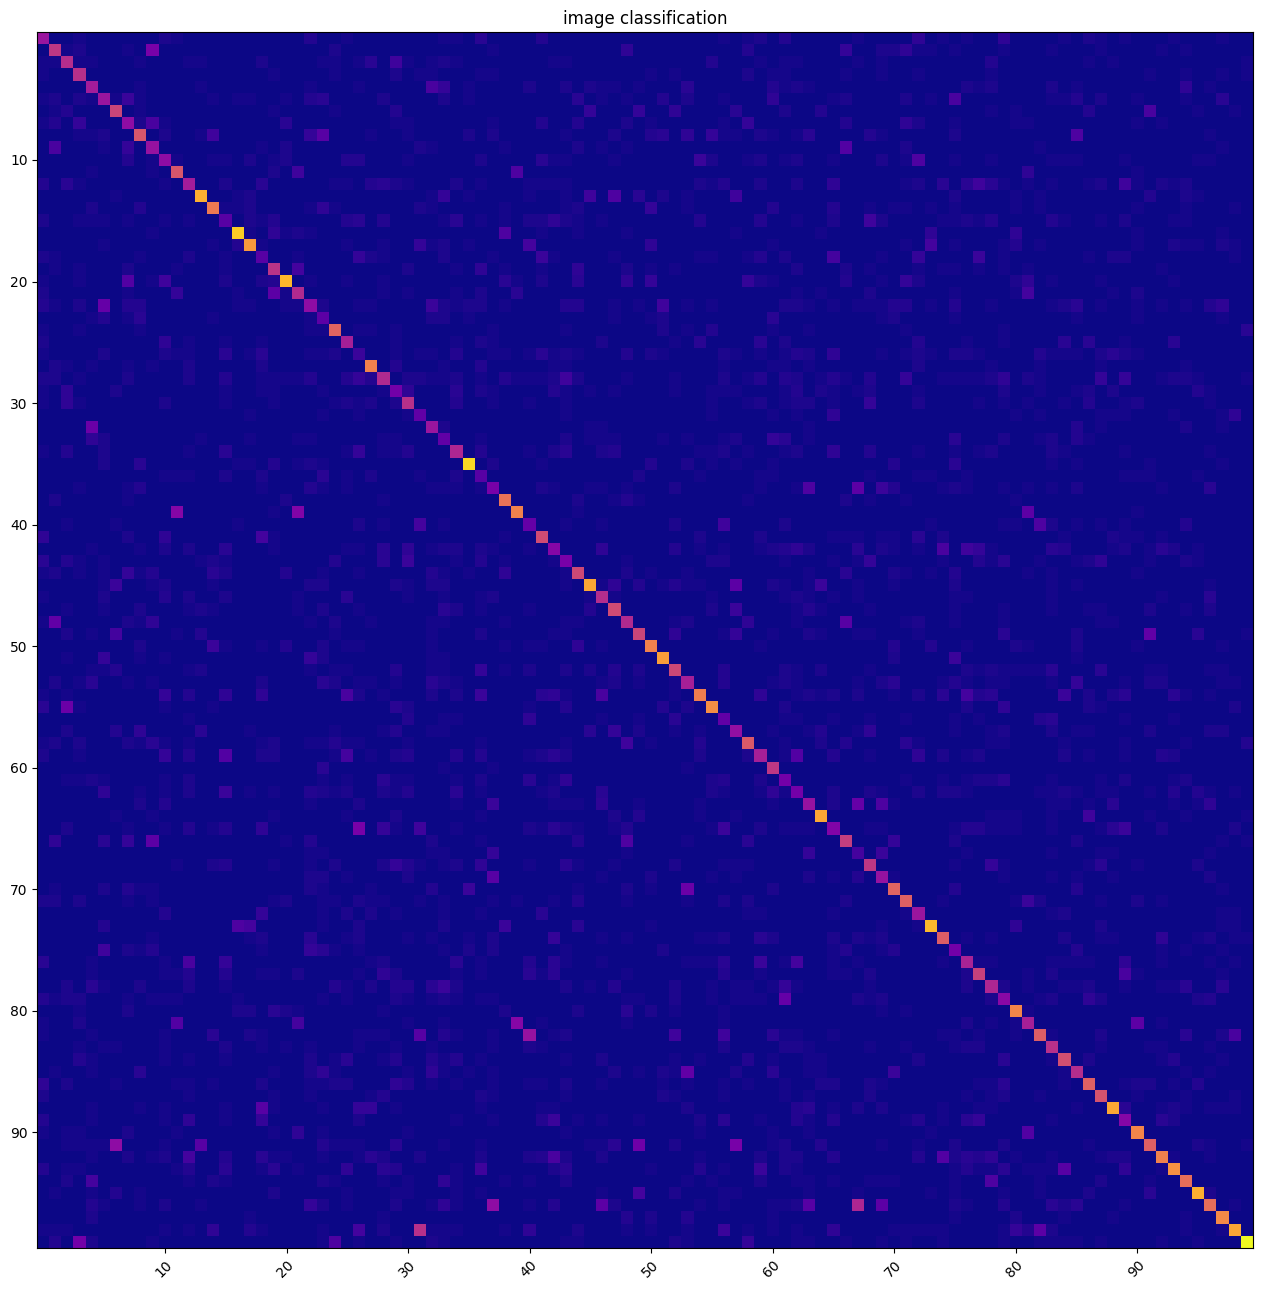

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print(len(matrice))

x = matrice[9]
l = lab[9]

#print()
#print(matrice[0])

l = [int(i) for i in l]
x = [int(i) for i in x]

cf = confusion_matrix(x,l)

fig, ax = plt.subplots(figsize=(15,13))
im = ax.imshow(cf,cmap='plasma')

ax.set_yticks([10,20,30,40,50,60,70,80,90])
ax.set_xticks([10,20,30,40,50,60,70,80,90])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("image classification")
fig.tight_layout()
plt.show()

**Accuracy trend plot**

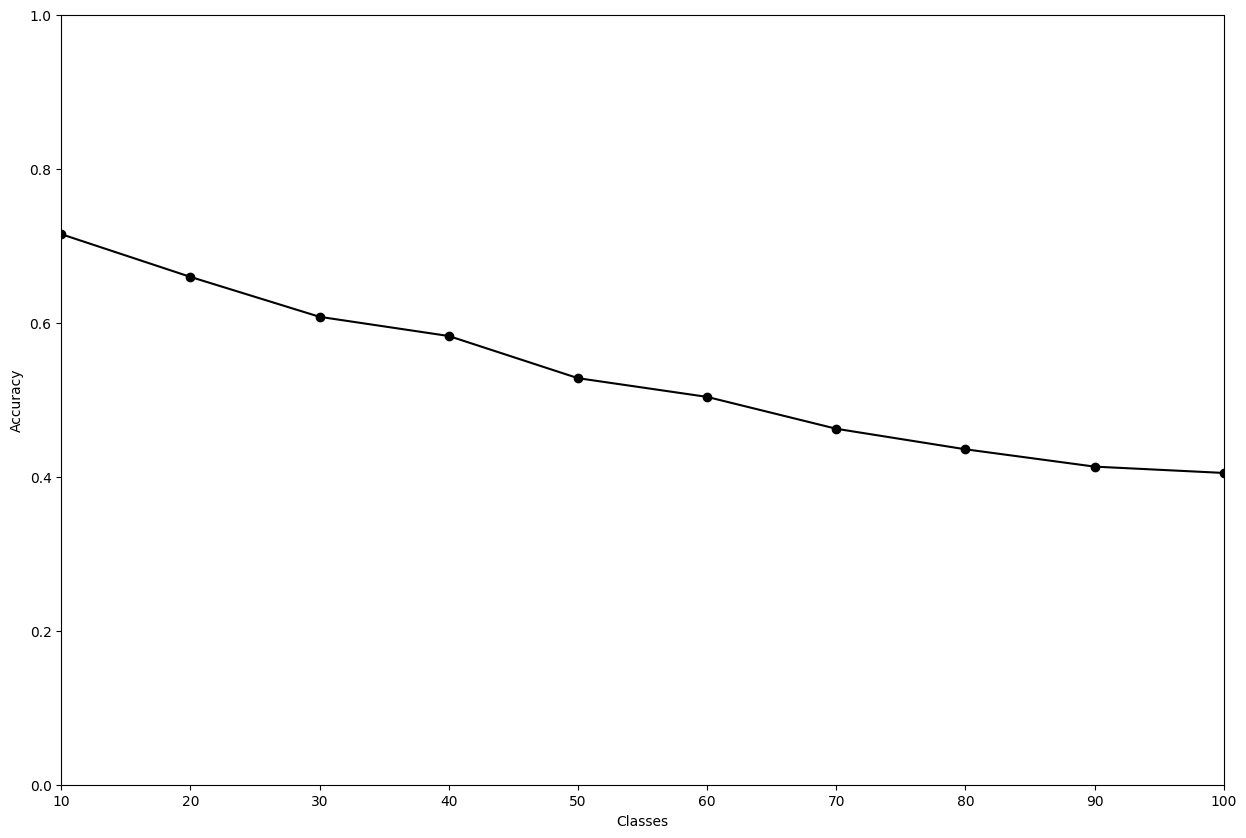

[0.7149999737739563, 0.659500002861023, 0.6076666712760925, 0.5827500224113464, 0.527999997138977, 0.5036666393280029, 0.46228572726249695, 0.43562498688697815, 0.4131111204624176, 0.4049000144004822]


In [ ]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot([10,20,30,40,50,60,70,80,90,100],best_acc,'k-o')
plt.xlim(10,100)
plt.ylim(0,1)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.show()

print(best_acc)

**Storing results**

In [ ]:
results_file = open("Results.txt","a")

results_file.write("accuracy:")
results_file.write(str(best_acc))

np.savetxt("CF_ICARL.txt",cf,delimiter = ',')

results_file.close()